# TRAINING VGG16 FOR MULTI-LABEL CLASSIFICATION

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Adding your absolute path of your project folder to system path
import sys
sys.path.append("/content/drive/My Drive/CS 553/archive/Multi_Label_dataset")

In [3]:
%cd "/content/drive/My Drive/CS553/archive/Multi_Label_dataset"

/content/drive/My Drive/CS553/archive/Multi_Label_dataset


In [4]:
# Checking status of gpu available through google collab
!nvidia-smi

Sun Dec  8 02:18:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Loading Data and Spliting in Train,Validation and Test

In [5]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        #Image id from csv file
        self.all_image_names = self.csv[:]['Id']
        #labels from train csv file
        self.all_labels = np.array(self.csv.drop(['Id', 'Genre'], axis=1))
        #Train-Validation data split (85% train and 15% validation)
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        #set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms - data augmentation
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
                transforms.Normalize(            # Normalize the tensor
                          mean=[0.5, 0.5, 0.5],  # Using ImageNet mean and std
                          std=[0.5, 0.5, 0.5]
                          )
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        # set the test data images and label (last 10 images)
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"Images/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            'image':image.clone().detach() if isinstance(image, torch.Tensor) else torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

#### Evaluation Metrics

In [6]:
from sklearn.metrics import average_precision_score,roc_auc_score
def compute_mAP(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

def comput_roc(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    ROC = []
    for i in range(y_true.shape[0]):
        ROC.append(roc_auc_score(y_true[i],y_pred[i]))
    return np.mean(ROC)

In [7]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro',zero_division=0),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro',zero_division=0),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples',zero_division=0)
            }

#### Creating Train Function

In [8]:
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        #setting gradients to zero
        optimizer.zero_grad()
        #forward pass
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        train_running_mAP += compute_mAP(outputs,target)
        train_running_ROC += comput_roc(outputs,target)
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

    train_loss = train_running_loss / counter
    train_mAP = train_running_mAP/counter
    train_ROC = train_running_ROC/counter
    print(f"Train mAP: {train_mAP:.4f}")
    print(f'Train ROC: {train_ROC:.4f}')
    return train_loss,train_mAP,train_ROC


#### Creating Validation Function

In [9]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_mAP = 0.0
    val_running_ROC = 0.0
    with torch.no_grad():
        model_result = []
        targets = []
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            model_result.extend(outputs.cpu().numpy())
            targets.extend(target.cpu().numpy())
            val_running_mAP += compute_mAP(outputs,target)
            val_running_ROC += comput_roc(outputs,target)
            val_running_loss += loss.item()
        result = calculate_metrics(np.array(model_result), np.array(targets))
        val_loss = val_running_loss / counter
        val_mAP = val_running_mAP/counter
        val_ROC = val_running_ROC/counter
        print("epoch:{:2d}  test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
        print(f"Val mAP: {val_mAP:.4f}")
        print(f'Val ROC: {val_ROC:.4f}')
        return val_loss,val_mAP,val_ROC

#VGG16 MODEL

In [10]:
from torchvision import models as models
import torch.nn as nn
def create_model(pretrained, requires_grad):
    model = models.vgg16(pretrained=True)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.classifier[6] = nn.Linear(4096, 25)
    return model
  #  model.fc = nn.Linear(2048, 25)
   # return model

#TRAINING

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#intialize the model
# Create a VGG16 model with frozen layers
model = create_model(pretrained=True, requires_grad=False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s] 


In [13]:
############ Traning for 4 epochs ############
#parameters
lr = 0.001
epochs = 4
batch_size = 256
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# read the training csv file
train_csv = pd.read_csv('train.csv')

# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False
)



Number of training images: 6165
Number of validation images: 1089


In [14]:
!pip install torchinfo

In [15]:
import torchinfo
from torchinfo import summary


# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape
VGG (VGG)                                [256, 3, 224, 224]
├─Sequential (features)                  [256, 3, 224, 224]
│    └─Conv2d (0)                        [256, 3, 224, 224]
│    └─ReLU (1)                          [256, 64, 224, 224]
│    └─Conv2d (2)                        [256, 64, 224, 224]
│    └─ReLU (3)                          [256, 64, 224, 224]
│    └─MaxPool2d (4)                     [256, 64, 224, 224]
│    └─Conv2d (5)                        [256, 64, 112, 112]
│    └─ReLU (6)                          [256, 128, 112, 112]
│    └─Conv2d (7)                        [256, 128, 112, 112]
│    └─ReLU (8)                          [256, 128, 112, 112]
│    └─MaxPool2d (9)                     [256, 128, 112, 112]
│    └─Conv2d (10)                       [256, 128, 56, 56]
│    └─ReLU (11)                         [256, 256, 56, 56]
│    └─Conv2d (12)                       [256, 256, 56, 56]
│    └─ReLU (13)                  

##### Training Run 1 - 4 epochs

In [16]:
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 4
Training


25it [28:32, 68.48s/it]


Train mAP: 0.5484
Train ROC: 0.8078
Validating


5it [05:13, 62.79s/it]


epoch: 0  test: micro f1: 0.313 macro f1: 0.060 samples f1: 0.285
Val mAP: 0.5307
Val ROC: 0.8045
Train Loss: 0.2897
Val Loss: 0.2516
Epoch 2 of 4
Training


25it [01:43,  4.13s/it]


Train mAP: 0.6044
Train ROC: 0.8538
Validating


5it [00:17,  3.57s/it]


epoch: 1  test: micro f1: 0.348 macro f1: 0.069 samples f1: 0.325
Val mAP: 0.5453
Val ROC: 0.8260
Train Loss: 0.2324
Val Loss: 0.2402
Epoch 3 of 4
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6162
Train ROC: 0.8661
Validating


5it [00:17,  3.46s/it]


epoch: 2  test: micro f1: 0.352 macro f1: 0.086 samples f1: 0.332
Val mAP: 0.5600
Val ROC: 0.8321
Train Loss: 0.2246
Val Loss: 0.2350
Epoch 4 of 4
Training


25it [01:43,  4.13s/it]


Train mAP: 0.6278
Train ROC: 0.8731
Validating


5it [00:17,  3.46s/it]

epoch: 3  test: micro f1: 0.368 macro f1: 0.100 samples f1: 0.336
Val mAP: 0.5537
Val ROC: 0.8325
Train Loss: 0.2195
Val Loss: 0.2371


In [22]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+4} of {epochs+4}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 5 of 8
Training


25it [01:50,  4.40s/it]


Train mAP: 0.6243
Train ROC: 0.8723
Validating


5it [00:17,  3.47s/it]


epoch: 0  test: micro f1: 0.352 macro f1: 0.105 samples f1: 0.316
Val mAP: 0.5659
Val ROC: 0.8402
Train Loss: 0.2195
Val Loss: 0.2302
Epoch 6 of 8
Training


25it [01:45,  4.21s/it]


Train mAP: 0.6299
Train ROC: 0.8752
Validating


5it [00:17,  3.54s/it]


epoch: 1  test: micro f1: 0.378 macro f1: 0.100 samples f1: 0.353
Val mAP: 0.5648
Val ROC: 0.8410
Train Loss: 0.2176
Val Loss: 0.2326
Epoch 7 of 8
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6287
Train ROC: 0.8771
Validating


5it [00:17,  3.57s/it]


epoch: 2  test: micro f1: 0.360 macro f1: 0.097 samples f1: 0.331
Val mAP: 0.5555
Val ROC: 0.8381
Train Loss: 0.2169
Val Loss: 0.2317
Epoch 8 of 8
Training


25it [01:43,  4.14s/it]


Train mAP: 0.6362
Train ROC: 0.8786
Validating


5it [00:17,  3.53s/it]

epoch: 3  test: micro f1: 0.400 macro f1: 0.113 samples f1: 0.378
Val mAP: 0.5680
Val ROC: 0.8444
Train Loss: 0.2150
Val Loss: 0.2321


In [28]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+8} of {epochs+8}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 8 of 12
Training


25it [01:43,  4.16s/it]


Train mAP: 0.6270
Train ROC: 0.8788
Validating


5it [00:17,  3.48s/it]


epoch: 0  test: micro f1: 0.372 macro f1: 0.104 samples f1: 0.349
Val mAP: 0.5672
Val ROC: 0.8416
Train Loss: 0.2162
Val Loss: 0.2298
Epoch 9 of 12
Training


25it [01:45,  4.23s/it]


Train mAP: 0.6312
Train ROC: 0.8780
Validating


5it [00:17,  3.47s/it]


epoch: 1  test: micro f1: 0.370 macro f1: 0.109 samples f1: 0.339
Val mAP: 0.5569
Val ROC: 0.8327
Train Loss: 0.2157
Val Loss: 0.2328
Epoch 10 of 12
Training


25it [01:45,  4.22s/it]


Train mAP: 0.6350
Train ROC: 0.8793
Validating


5it [00:17,  3.49s/it]


epoch: 2  test: micro f1: 0.361 macro f1: 0.105 samples f1: 0.329
Val mAP: 0.5620
Val ROC: 0.8331
Train Loss: 0.2156
Val Loss: 0.2309
Epoch 11 of 12
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6328
Train ROC: 0.8802
Validating


5it [00:17,  3.55s/it]

epoch: 3  test: micro f1: 0.369 macro f1: 0.106 samples f1: 0.342
Val mAP: 0.5496
Val ROC: 0.8305
Train Loss: 0.2146
Val Loss: 0.2329


In [34]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+12} of {epochs+12}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 13 of 16
Training


25it [01:46,  4.28s/it]


Train mAP: 0.6369
Train ROC: 0.8803
Validating


5it [00:17,  3.52s/it]


epoch: 0  test: micro f1: 0.376 macro f1: 0.111 samples f1: 0.347
Val mAP: 0.5549
Val ROC: 0.8324
Train Loss: 0.2156
Val Loss: 0.2329
Epoch 14 of 16
Training


25it [01:44,  4.18s/it]


Train mAP: 0.6375
Train ROC: 0.8818
Validating


5it [00:17,  3.57s/it]


epoch: 1  test: micro f1: 0.353 macro f1: 0.110 samples f1: 0.319
Val mAP: 0.5632
Val ROC: 0.8383
Train Loss: 0.2132
Val Loss: 0.2293
Epoch 15 of 16
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6337
Train ROC: 0.8813
Validating


5it [00:17,  3.54s/it]


epoch: 2  test: micro f1: 0.376 macro f1: 0.111 samples f1: 0.348
Val mAP: 0.5598
Val ROC: 0.8404
Train Loss: 0.2136
Val Loss: 0.2318
Epoch 16 of 16
Training


25it [01:44,  4.19s/it]


Train mAP: 0.6358
Train ROC: 0.8812
Validating


5it [00:17,  3.50s/it]

epoch: 3  test: micro f1: 0.384 macro f1: 0.108 samples f1: 0.356
Val mAP: 0.5634
Val ROC: 0.8375
Train Loss: 0.2150
Val Loss: 0.2310


In [39]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+16} of {epochs+16}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 17 of 20
Training


25it [01:48,  4.32s/it]


Train mAP: 0.6362
Train ROC: 0.8840
Validating


5it [00:17,  3.52s/it]


epoch: 0  test: micro f1: 0.376 macro f1: 0.109 samples f1: 0.343
Val mAP: 0.5620
Val ROC: 0.8404
Train Loss: 0.2133
Val Loss: 0.2312
Epoch 18 of 20
Training


25it [01:44,  4.20s/it]


Train mAP: 0.6414
Train ROC: 0.8854
Validating


5it [00:17,  3.47s/it]


epoch: 1  test: micro f1: 0.374 macro f1: 0.104 samples f1: 0.344
Val mAP: 0.5626
Val ROC: 0.8343
Train Loss: 0.2114
Val Loss: 0.2311
Epoch 19 of 20
Training


25it [01:44,  4.19s/it]


Train mAP: 0.6406
Train ROC: 0.8835
Validating


5it [00:17,  3.50s/it]


epoch: 2  test: micro f1: 0.379 macro f1: 0.109 samples f1: 0.352
Val mAP: 0.5505
Val ROC: 0.8317
Train Loss: 0.2125
Val Loss: 0.2358
Epoch 20 of 20
Training


25it [01:44,  4.18s/it]


Train mAP: 0.6346
Train ROC: 0.8820
Validating


5it [00:17,  3.43s/it]

epoch: 3  test: micro f1: 0.377 macro f1: 0.113 samples f1: 0.348
Val mAP: 0.5649
Val ROC: 0.8345
Train Loss: 0.2140
Val Loss: 0.2322


In [44]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+20} of {epochs+20}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 21 of 24
Training


25it [01:45,  4.23s/it]


Train mAP: 0.6441
Train ROC: 0.8838
Validating


5it [00:17,  3.58s/it]


epoch: 0  test: micro f1: 0.381 macro f1: 0.107 samples f1: 0.362
Val mAP: 0.5671
Val ROC: 0.8390
Train Loss: 0.2124
Val Loss: 0.2299
Epoch 22 of 24
Training


25it [01:43,  4.13s/it]


Train mAP: 0.6393
Train ROC: 0.8845
Validating


5it [00:17,  3.57s/it]


epoch: 1  test: micro f1: 0.376 macro f1: 0.106 samples f1: 0.350
Val mAP: 0.5663
Val ROC: 0.8322
Train Loss: 0.2138
Val Loss: 0.2323
Epoch 23 of 24
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6410
Train ROC: 0.8848
Validating


5it [00:17,  3.46s/it]


epoch: 2  test: micro f1: 0.370 macro f1: 0.111 samples f1: 0.335
Val mAP: 0.5700
Val ROC: 0.8436
Train Loss: 0.2118
Val Loss: 0.2301
Epoch 24 of 24
Training


25it [01:44,  4.16s/it]


Train mAP: 0.6416
Train ROC: 0.8838
Validating


5it [00:17,  3.48s/it]

epoch: 3  test: micro f1: 0.369 macro f1: 0.116 samples f1: 0.336
Val mAP: 0.5597
Val ROC: 0.8315
Train Loss: 0.2123
Val Loss: 0.2350


In [54]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+24} of {epochs+24}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 25 of 28
Training


25it [01:55,  4.61s/it]


Train mAP: 0.6384
Train ROC: 0.8833
Validating


5it [00:17,  3.56s/it]


epoch: 0  test: micro f1: 0.366 macro f1: 0.116 samples f1: 0.330
Val mAP: 0.5685
Val ROC: 0.8379
Train Loss: 0.2136
Val Loss: 0.2321
Epoch 26 of 28
Training


25it [01:46,  4.27s/it]


Train mAP: 0.6416
Train ROC: 0.8836
Validating


5it [00:17,  3.49s/it]


epoch: 1  test: micro f1: 0.339 macro f1: 0.111 samples f1: 0.301
Val mAP: 0.5606
Val ROC: 0.8386
Train Loss: 0.2131
Val Loss: 0.2313
Epoch 27 of 28
Training


25it [01:44,  4.18s/it]


Train mAP: 0.6365
Train ROC: 0.8845
Validating


5it [00:17,  3.58s/it]


epoch: 2  test: micro f1: 0.367 macro f1: 0.117 samples f1: 0.334
Val mAP: 0.5616
Val ROC: 0.8324
Train Loss: 0.2133
Val Loss: 0.2336
Epoch 28 of 28
Training


25it [01:46,  4.27s/it]


Train mAP: 0.6420
Train ROC: 0.8852
Validating


5it [00:17,  3.57s/it]

epoch: 3  test: micro f1: 0.349 macro f1: 0.101 samples f1: 0.318
Val mAP: 0.5597
Val ROC: 0.8347
Train Loss: 0.2124
Val Loss: 0.2331


In [61]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+28} of {epochs+28}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 29 of 32
Training


25it [01:48,  4.36s/it]


Train mAP: 0.6389
Train ROC: 0.8858
Validating


5it [00:17,  3.49s/it]


epoch: 0  test: micro f1: 0.391 macro f1: 0.110 samples f1: 0.368
Val mAP: 0.5647
Val ROC: 0.8349
Train Loss: 0.2122
Val Loss: 0.2346
Epoch 30 of 32
Training


25it [01:44,  4.19s/it]


Train mAP: 0.6434
Train ROC: 0.8869
Validating


5it [00:17,  3.49s/it]


epoch: 1  test: micro f1: 0.363 macro f1: 0.118 samples f1: 0.335
Val mAP: 0.5673
Val ROC: 0.8399
Train Loss: 0.2114
Val Loss: 0.2317
Epoch 31 of 32
Training


25it [01:45,  4.22s/it]


Train mAP: 0.6373
Train ROC: 0.8806
Validating


5it [00:17,  3.51s/it]


epoch: 2  test: micro f1: 0.364 macro f1: 0.111 samples f1: 0.334
Val mAP: 0.5580
Val ROC: 0.8307
Train Loss: 0.2139
Val Loss: 0.2344
Epoch 32 of 32
Training


25it [01:44,  4.20s/it]


Train mAP: 0.6347
Train ROC: 0.8835
Validating


5it [00:17,  3.49s/it]

epoch: 3  test: micro f1: 0.387 macro f1: 0.118 samples f1: 0.358
Val mAP: 0.5695
Val ROC: 0.8423
Train Loss: 0.2136
Val Loss: 0.2300


In [66]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+32} of {epochs+32}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 33 of 36
Training


25it [01:46,  4.25s/it]


Train mAP: 0.6403
Train ROC: 0.8859
Validating


5it [00:17,  3.48s/it]


epoch: 0  test: micro f1: 0.369 macro f1: 0.105 samples f1: 0.345
Val mAP: 0.5577
Val ROC: 0.8312
Train Loss: 0.2118
Val Loss: 0.2349
Epoch 34 of 36
Training


25it [01:43,  4.16s/it]


Train mAP: 0.6432
Train ROC: 0.8859
Validating


5it [00:17,  3.57s/it]


epoch: 1  test: micro f1: 0.395 macro f1: 0.120 samples f1: 0.382
Val mAP: 0.5631
Val ROC: 0.8387
Train Loss: 0.2121
Val Loss: 0.2352
Epoch 35 of 36
Training


25it [01:44,  4.17s/it]


Train mAP: 0.6411
Train ROC: 0.8854
Validating


5it [00:17,  3.55s/it]


epoch: 2  test: micro f1: 0.377 macro f1: 0.115 samples f1: 0.353
Val mAP: 0.5647
Val ROC: 0.8357
Train Loss: 0.2121
Val Loss: 0.2331
Epoch 36 of 36
Training


25it [01:45,  4.21s/it]


Train mAP: 0.6421
Train ROC: 0.8872
Validating


5it [00:21,  4.29s/it]

epoch: 3  test: micro f1: 0.385 macro f1: 0.119 samples f1: 0.357
Val mAP: 0.5545
Val ROC: 0.8328
Train Loss: 0.2103
Val Loss: 0.2350


In [71]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+36} of {epochs+36}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 37 of 40
Training


25it [01:46,  4.27s/it]


Train mAP: 0.6442
Train ROC: 0.8845
Validating


5it [00:18,  3.70s/it]


epoch: 0  test: micro f1: 0.364 macro f1: 0.105 samples f1: 0.343
Val mAP: 0.5553
Val ROC: 0.8320
Train Loss: 0.2122
Val Loss: 0.2352
Epoch 38 of 40
Training


25it [01:44,  4.20s/it]


Train mAP: 0.6476
Train ROC: 0.8873
Validating


5it [00:21,  4.33s/it]


epoch: 1  test: micro f1: 0.374 macro f1: 0.108 samples f1: 0.349
Val mAP: 0.5655
Val ROC: 0.8387
Train Loss: 0.2111
Val Loss: 0.2313
Epoch 39 of 40
Training


25it [01:44,  4.19s/it]


Train mAP: 0.6395
Train ROC: 0.8861
Validating


5it [00:17,  3.52s/it]


epoch: 2  test: micro f1: 0.354 macro f1: 0.105 samples f1: 0.330
Val mAP: 0.5621
Val ROC: 0.8333
Train Loss: 0.2119
Val Loss: 0.2333
Epoch 40 of 40
Training


25it [01:45,  4.21s/it]


Train mAP: 0.6444
Train ROC: 0.8876
Validating


5it [00:17,  3.51s/it]

epoch: 3  test: micro f1: 0.374 macro f1: 0.108 samples f1: 0.343
Val mAP: 0.5611
Val ROC: 0.8382
Train Loss: 0.2103
Val Loss: 0.2330


In [72]:
epochs_comp = 40
epochs_comp

40

In [76]:
 # save the trained model to disk
 torch.save({
     'epoch': epochs_comp,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': criterion,
     'Train_loss': train_loss,
     'Valid_loss': valid_loss,
     'Train_mAP': train_mAP,
     'Train_ROC': train_ROC,
     'Valid_mAP': valid_mAP,
     'Valid_ROC': valid_ROC
                 }, 'model2.pth')

# PLOTTONG GRAPHS

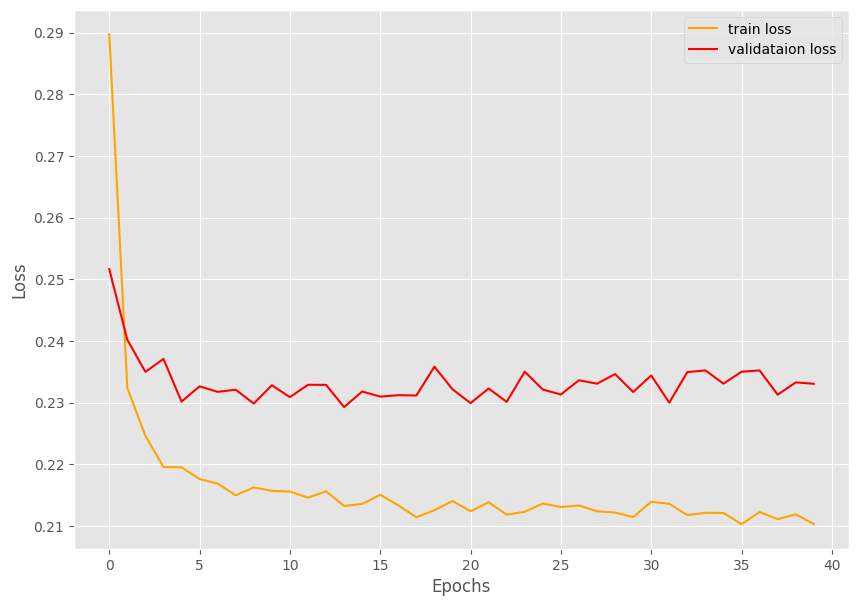

In [73]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../loss_40epochs.png')
plt.show()

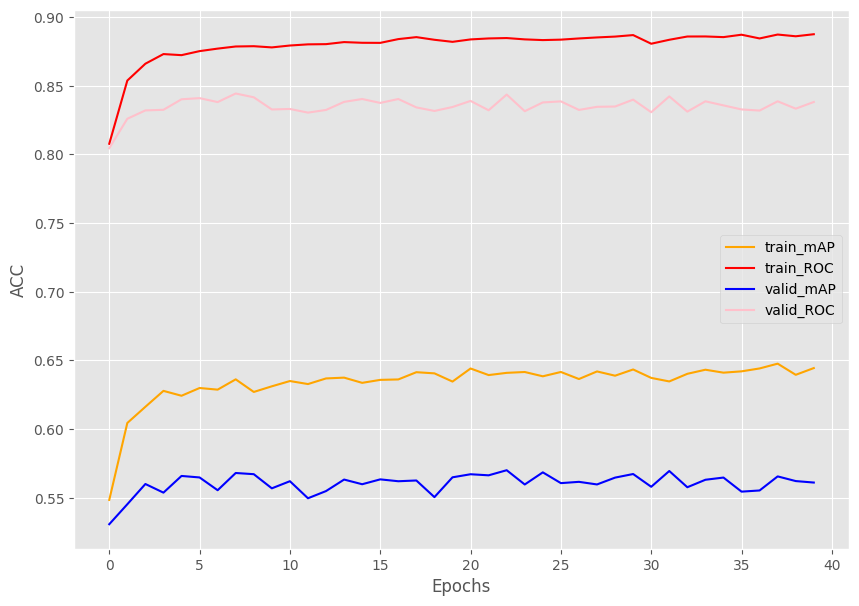

In [74]:
plt.figure(figsize=(10, 7))
plt.plot(train_mAP, color='orange', label='train_mAP')
plt.plot(train_ROC, color='red', label='train_ROC')
plt.plot(valid_mAP, color='blue',label ='valid_mAP')
plt.plot(valid_ROC, color='pink', label='valid_ROC')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.savefig('../ACC_40epochs.png')
plt.show()

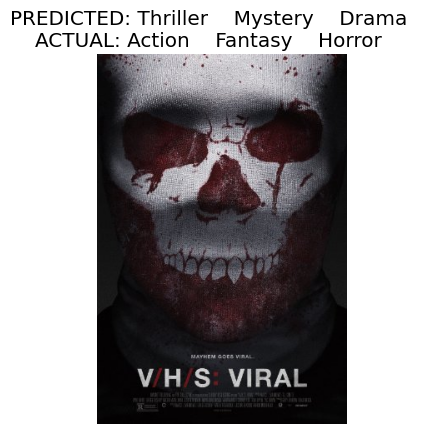

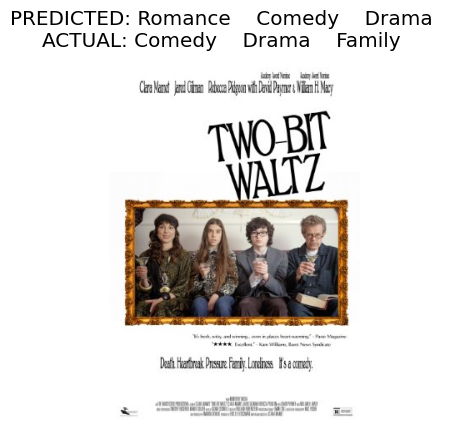

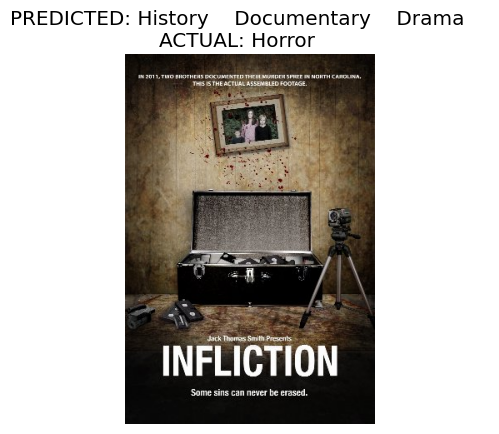

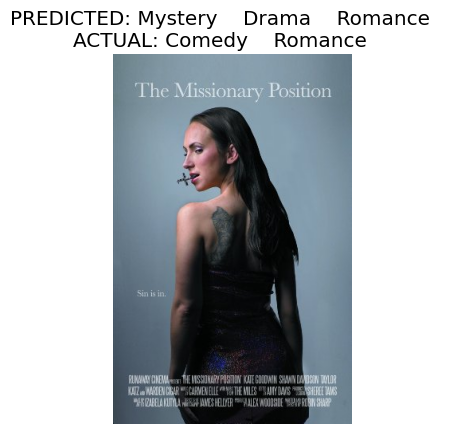

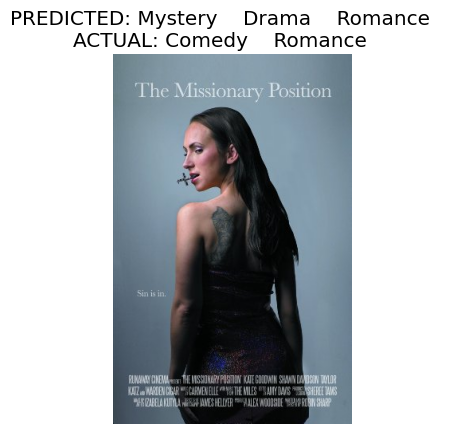

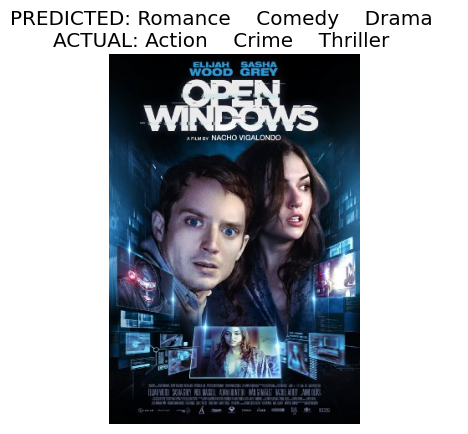

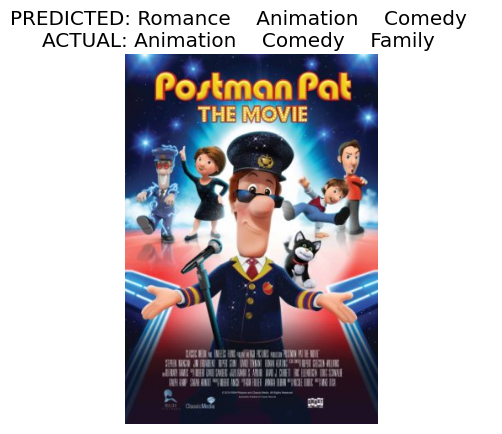

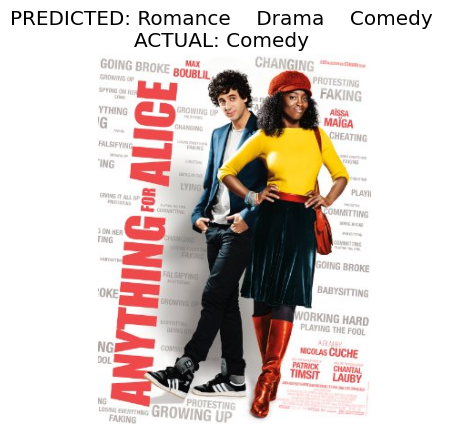

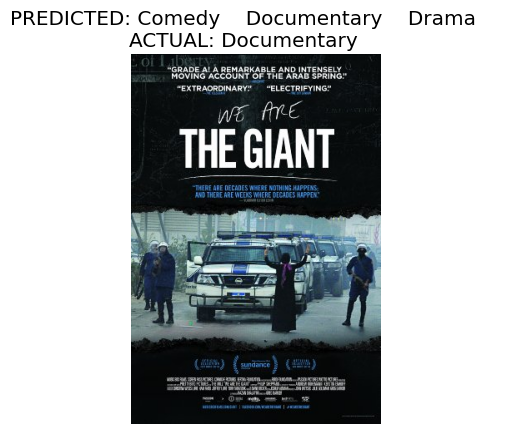

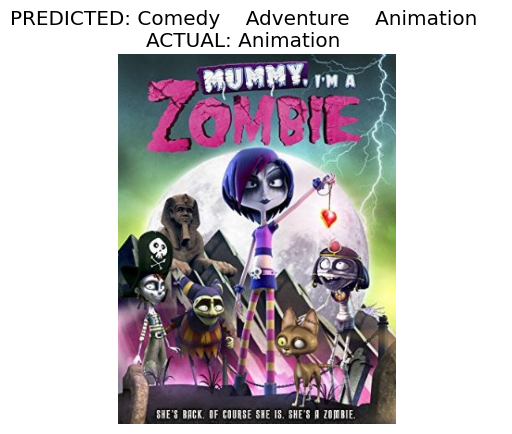

In [75]:
train_csv = pd.read_csv('train.csv')
genres = train_csv.columns.values[2:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)
all_preds = []
all_labels = []
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label'].to(device)
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    ########## included later ###############
    all_preds.append(preds.cpu().numpy())
    all_labels.append(target.cpu().numpy())
    #########################################
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"inference_{counter}.jpg")
    plt.show()


